## To-do list:
* after-pulse and crosstalk calibration
* save calibration results in files:
    * breakdown voltage and gain at any voltage
    * after-pulse and crosstalk
    * spe pulse shape time constants and coefficients
* add sipm class methods and members:
    * ar_filter()
    * trigger_position
    * spe_waveform (read from file)
    * change integration window
    * 
* theoretical beta spectrum
* convolute theoretical spectrum with after-pulses and crosstalk smearing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from scipy.optimize import curve_fit
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def expo_scint(x,a,tau):
    return a*np.exp(-x/tau)

# Scintillation data top 1006

## Directory

In [3]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/"
subdir = ["2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/","2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_1/","2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_2/","2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_3/"]

In [4]:
summed_integral_pe_datasets = []
avgwf_datasets = []
time_datasets = []
for subdir_ in subdir:
    avgwf_ch = []
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4))
    for i in range(4):
        print(data.ch[i].file)
        data.ch[i].read_data()
        data.ch[i].baseline_subtraction()
        data.ch[i].get_avgwf()
        avgwf_ch.append(data.ch[i].avgwf)
        data.ch[i].get_integral()
        data.ch[i].clear()
        if i==0:
            time_datasets.append(data.ch[i].time)
    avgwf_datasets.append(avgwf_ch)
    data.get_summed_integral_pe()
    summed_integral_pe_datasets.append(data.summed_integral_pe)
    print("summed charge")


/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave0.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave1.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave2.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave3.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1176
NUMBER OF WAVEFORMS = 163183
summed charge
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light

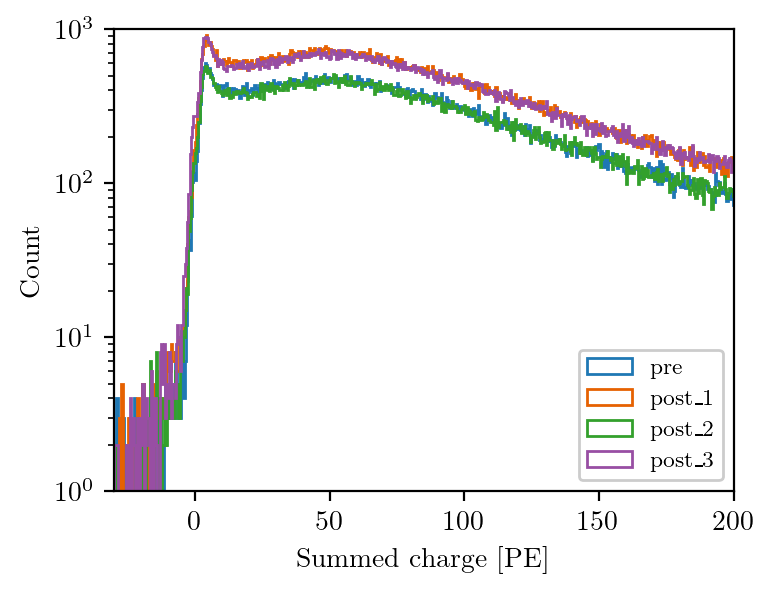

In [19]:
xmin = -30
xmax = 200
nbins = 500
plt.figure()
labels = ['pre', 'post_1', 'post_2', 'post_3']
for i,integral in enumerate(summed_integral_pe_datasets):
    plt.hist(integral, bins=np.linspace(xmin,xmax,nbins), histtype='step', label=labels[i])
plt.yscale('log')
plt.legend(loc='lower right')
plt.xlim(xmin, xmax)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Count')
plt.show()

A=3089.2909731473474  TAU=1.2263726786566265us
A=3016.9992908794234  TAU=1.2321526973053296us
A=2842.1694035050887  TAU=1.2544088129288076us
A=2689.4999811032626  TAU=1.2734564504764392us
A=1008.7941914526  TAU=1.5851860773738804us
A=966.0900466022563  TAU=1.6025606535804997us
A=926.1792249740777  TAU=1.6320482833675196us
A=908.6417638629785  TAU=1.6467019635782685us
A=2318.64536884144  TAU=1.3025453518823185us
A=2188.66008508962  TAU=1.3200225594412032us
A=2090.4978970680104  TAU=1.3412759944515213us
A=2015.869361686032  TAU=1.3565031526687281us
A=1269.4604921593673  TAU=1.4860519425286578us
A=1221.4702089183565  TAU=1.500615536990773us
A=1162.3721105118295  TAU=1.5296079685710804us
A=1137.0761399289672  TAU=1.5431692667048917us


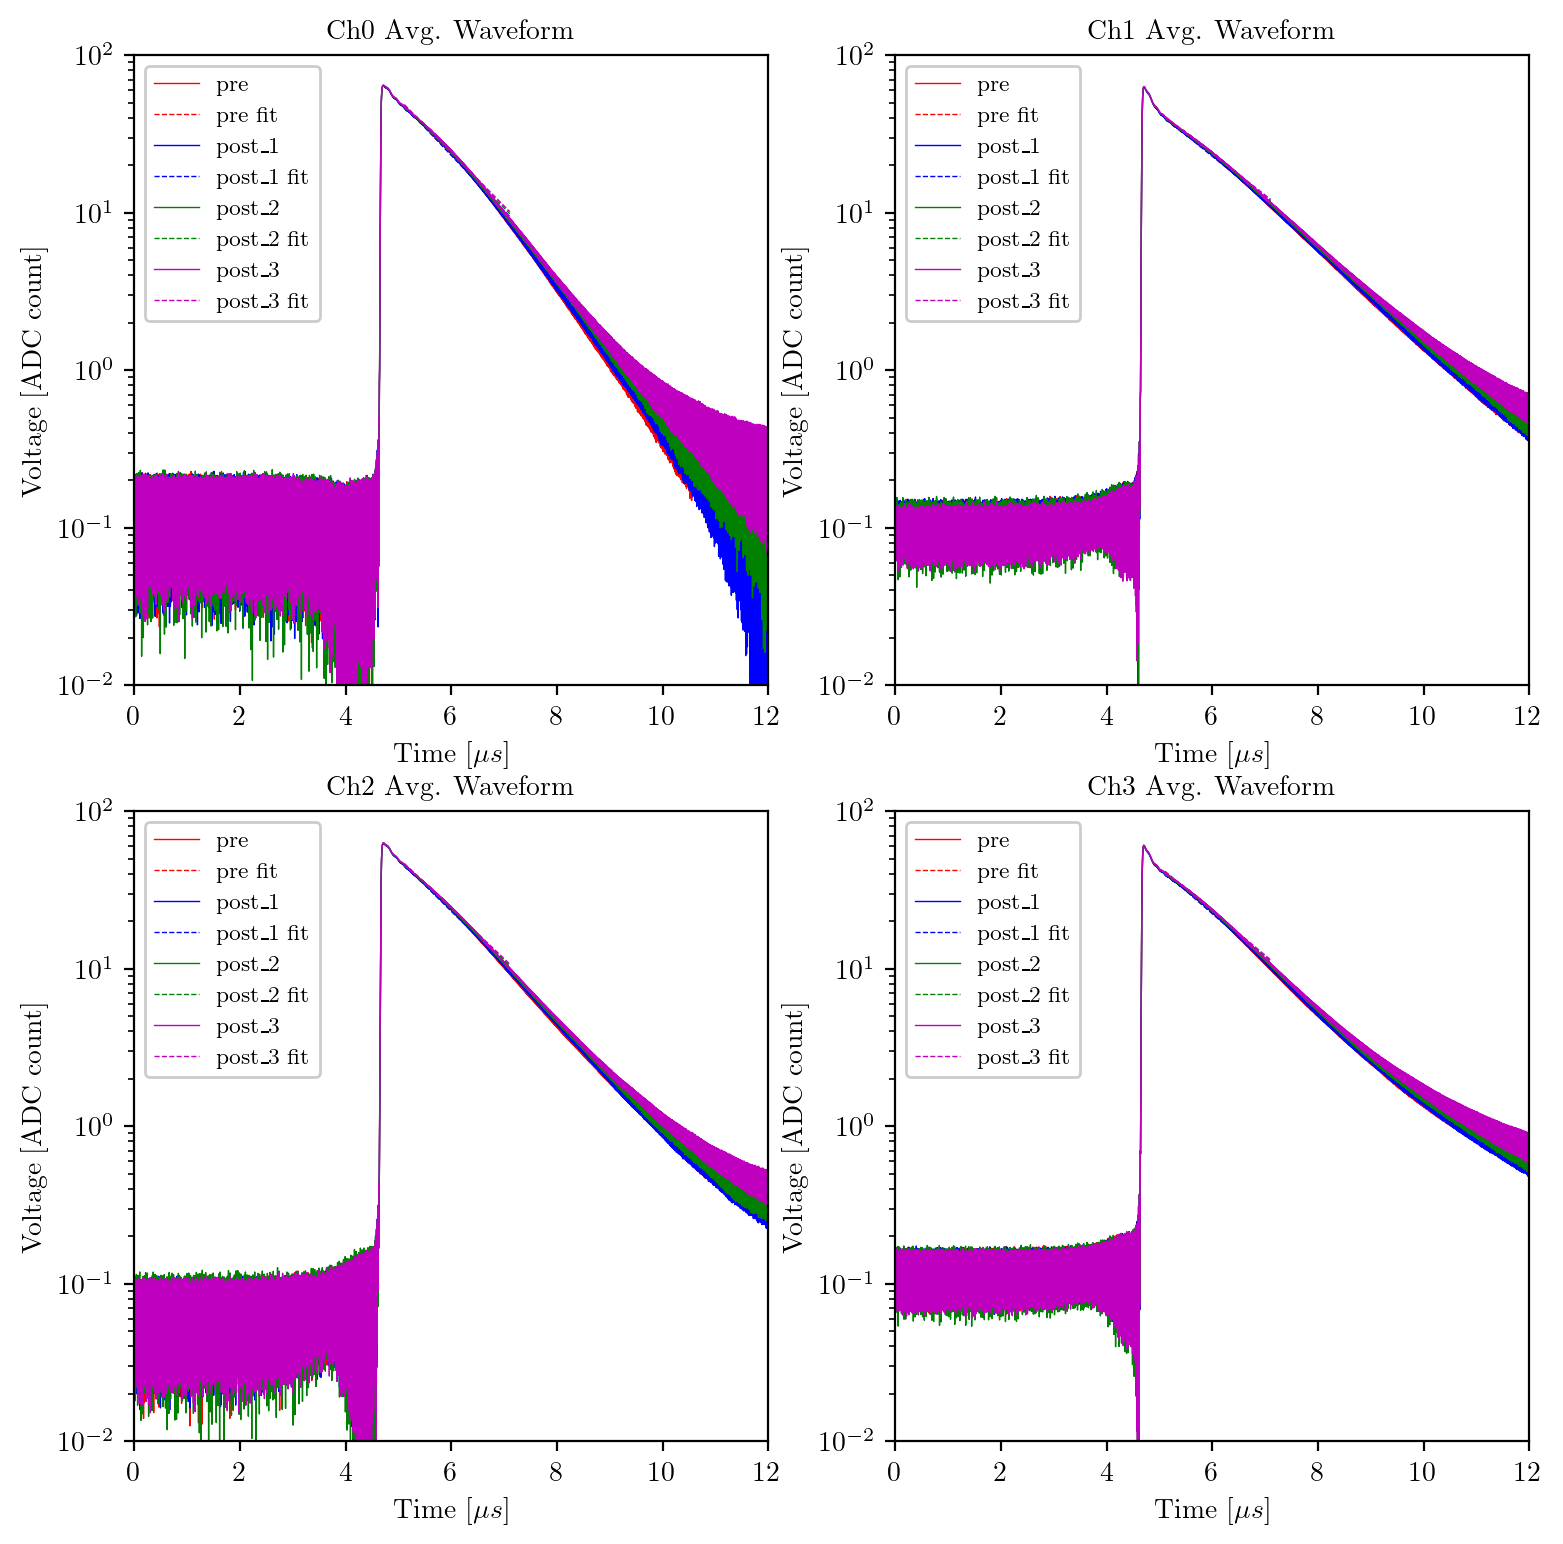

In [6]:
tau_ch_datasets = []
plt.figure(0,figsize=(9,9))
labels = ['pre', 'post_1', 'post_2', 'post_3']
colors = ['r','b','g','m']
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    tau_datasets = []
    for i,avgwf in enumerate(avgwf_datasets):
        plt.plot(time_datasets[i], abs(avgwf[ch]), "{}-".format(colors[i]), label=labels[i], linewidth=0.5, )
        trig_pos = np.argmax(avgwf[ch])
        trig_height = np.max(avgwf[ch])
        popt,pcov = curve_fit(expo_scint, time_datasets[i][trig_pos+100:trig_pos+600], avgwf[ch][trig_pos+100:trig_pos+600], p0=[trig_height/np.exp(-trig_pos*4e-3/1.5),1.5],maxfev=10000)
        print('A={}  TAU={}us'.format(popt[0],popt[1]))
        tau_datasets.append(popt[1])
        plt.plot(time_datasets[i][trig_pos+100:trig_pos+600], expo_scint(time_datasets[i][trig_pos+100:trig_pos+600], *popt), "{}--".format(colors[i]), label='{} fit'.format(labels[i]), linewidth=0.5)
    tau_ch_datasets.append(tau_datasets)
    plt.legend()
    plt.xlim(0,12)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

# Scintillation data top 1007

In [7]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/"
subdir = ["2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/","2022-10-07/2022-10-07_volt_70_pos_top_light_scint_1/","2022-10-07/2022-10-07_volt_70_pos_top_light_scint_2/","2022-10-07/2022-10-07_volt_70_pos_top_light_scint_3/", "2022-10-07/2022-10-07_volt_70_pos_top_light_scint_4/", "2022-10-07/2022-10-07_volt_70_pos_top_light_scint_5/"]

In [8]:
summed_integral_pe_datasets_1007 = []
avgwf_datasets_1007 = []
time_datasets_1007 = []
for subdir_ in subdir:
    avgwf_ch = []
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4))
    for i in range(4):
        print(data.ch[i].file)
        print("Analyzing channel {}".format(i))
        data.ch[i].read_data()
        print("read data")
        data.ch[i].baseline_subtraction()
        print("baseline")
        data.ch[i].get_avgwf()
        avgwf_ch.append(data.ch[i].avgwf)
        print("average waveform")
        data.ch[i].get_integral()
        print("get_integral")
        data.ch[i].clear()
        print("clear")
        if i==0:
            time_datasets_1007.append(data.ch[i].time)
    avgwf_datasets_1007.append(avgwf_ch)
    data.get_summed_integral_pe()
    summed_integral_pe_datasets_1007.append(data.summed_integral_pe)
    print("summed charge")


/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave0.dat
Analyzing channel 0
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1180
NUMBER OF WAVEFORMS = 9966
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave1.dat
Analyzing channel 1
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 9966
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave2.dat
Analyzing channel 2
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 9966
read data
baseline
average waveform
get_integral
clear
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/wave3.dat
Analyzing channel 3
WAVEFORM LENGTH = 3000 SAMPLES
TRIGG

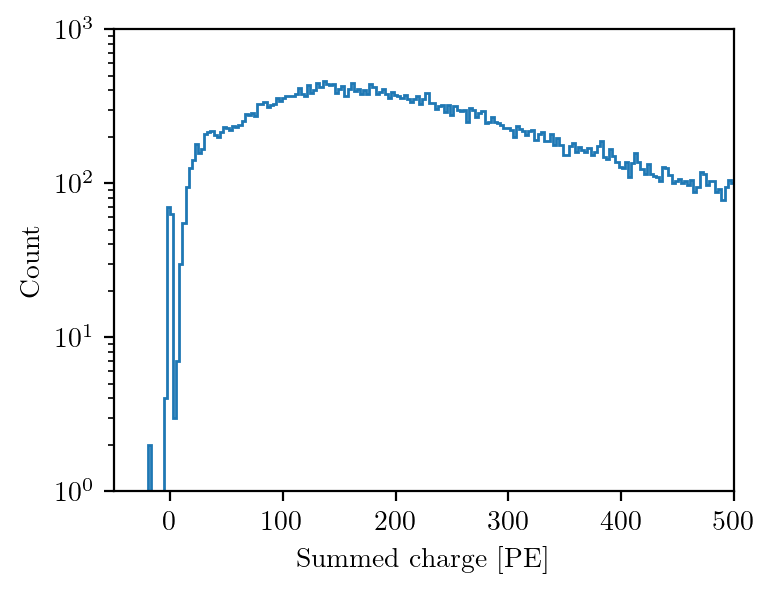

In [9]:
xmin = -50
xmax = 500
nbins = 200
plt.figure()
merge_integral = []
for i,integral in enumerate(summed_integral_pe_datasets_1007):
    merge_integral = merge_integral + list(integral)
plt.hist(merge_integral, bins=np.linspace(xmin,xmax,nbins), histtype='step')
plt.yscale('log')
plt.xlim(xmin, xmax)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Count')
plt.show()

A=3001.877202050086  TAU=1.5371229154739077 us$
A=1029.1221420598167  TAU=2.1109135155449383 us$
A=2251.2653971174554  TAU=1.663097919282839 us$
A=1290.3093258739916  TAU=1.953928788302212 us$


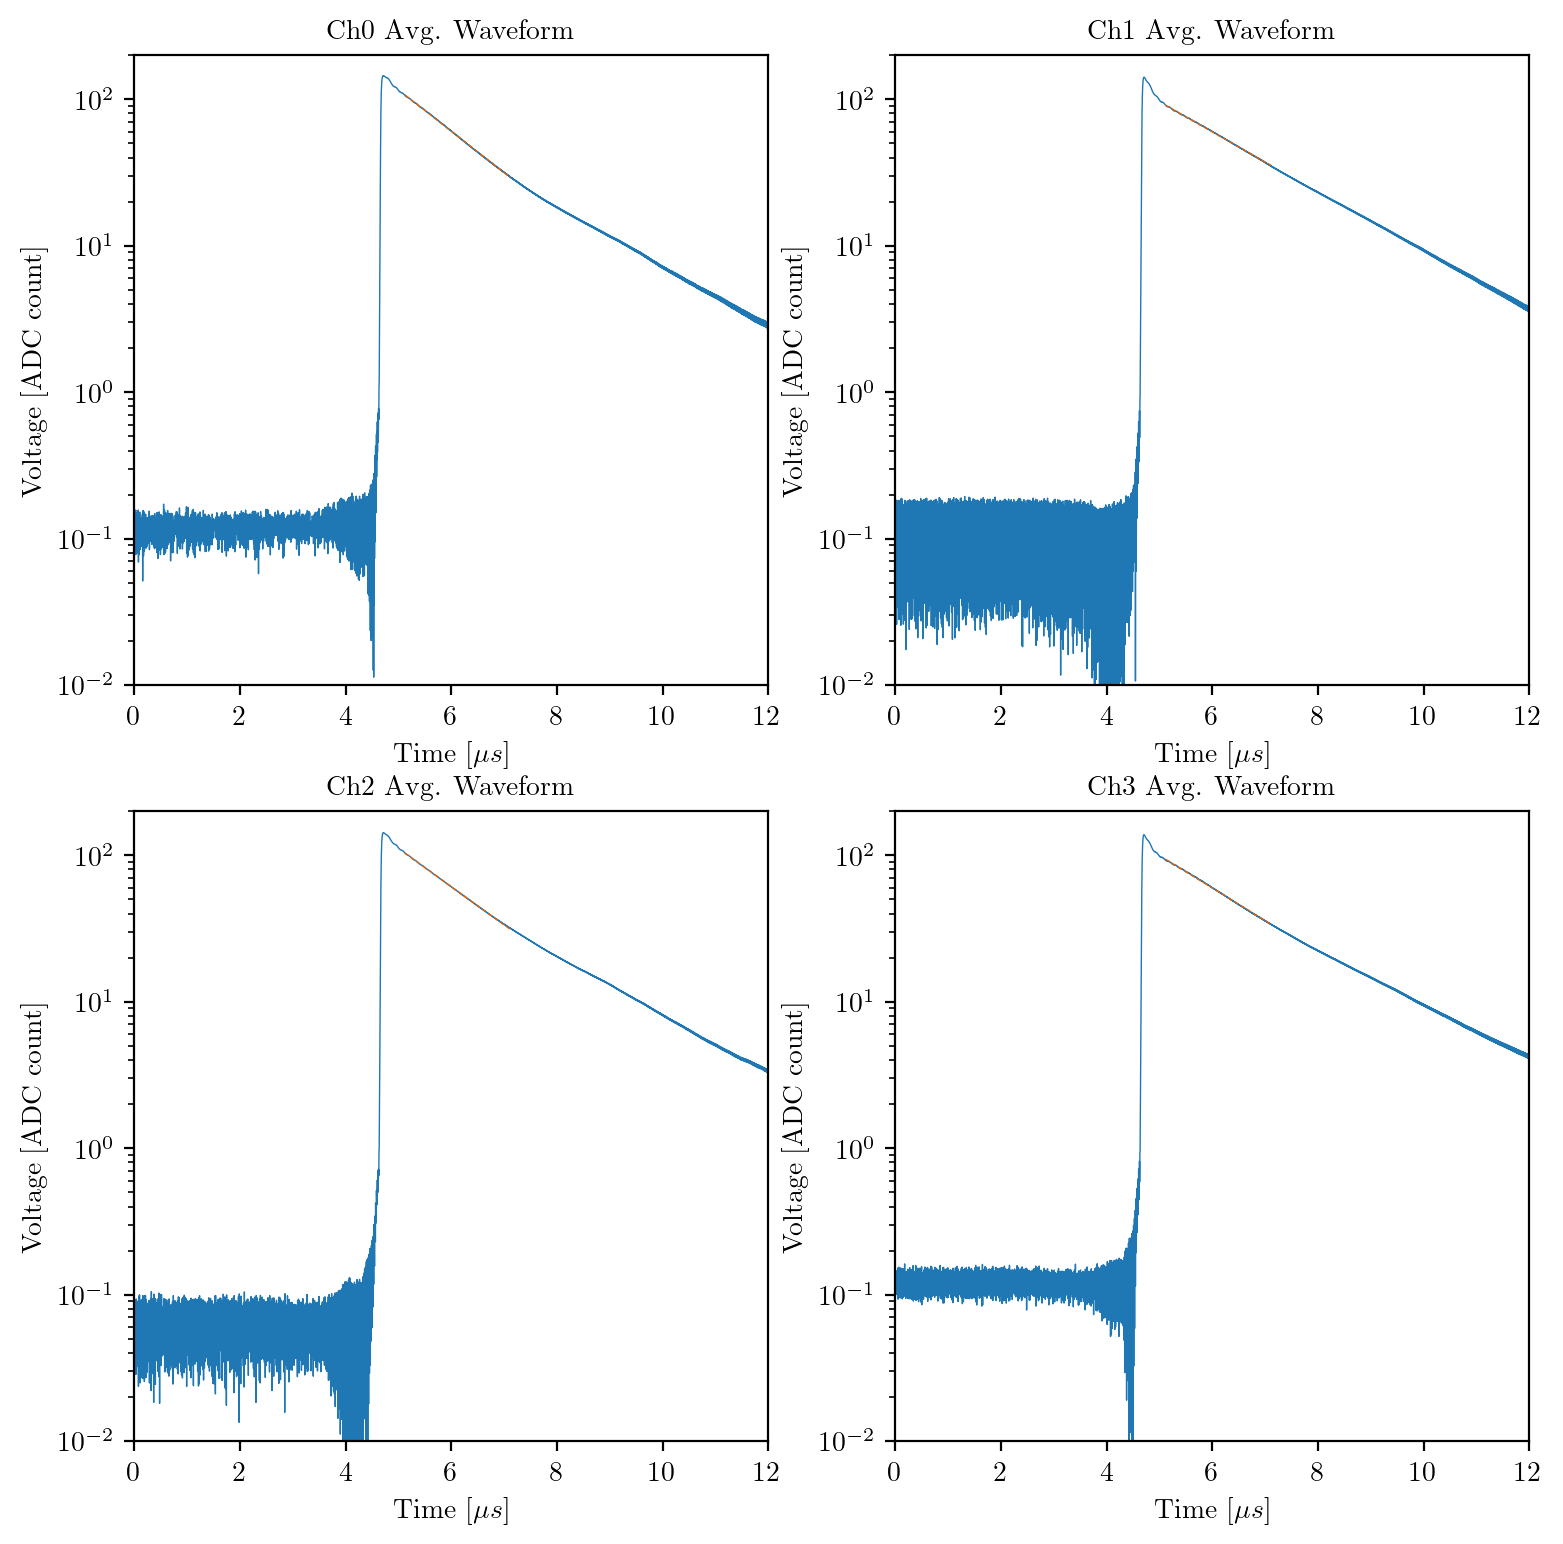

In [10]:
plt.figure(0,figsize=(9,9))
avgwf_overall = np.zeros((4,np.shape(avgwf_datasets_1007)[2]))
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    for i,avgwf in enumerate(avgwf_datasets_1007):
        avgwf_overall[ch] = np.mean(np.array(avgwf_datasets_1007)[:,ch,:], axis=0)
    plt.plot(time_datasets_1007[0], abs(avgwf_overall[ch]), '-', label = '10-07', linewidth=0.5)
    trig_pos = np.argmax(avgwf_overall[ch])
    trig_height = np.max(avgwf_overall[ch])
    popt,pcov = curve_fit(expo_scint, time_datasets_1007[0][trig_pos+100:trig_pos+600], avgwf_overall[ch][trig_pos+100:trig_pos+600], p0=[trig_height/np.exp(-trig_pos*4e-3/1.5),1.5],maxfev=10000)
    print(r'A={}  TAU={} us$'.format(popt[0],popt[1]))
    tau_ch_datasets[ch].append(popt[1])
    plt.plot(time_datasets_1007[0][trig_pos+100:trig_pos+600], expo_scint(time_datasets_1007[0][trig_pos+100:trig_pos+600], *popt), "--", label='10-07 fit', linewidth=0.5)

    plt.xlim(0,12)
    plt.ylim(1e-2, 200)
    plt.yscale('log')

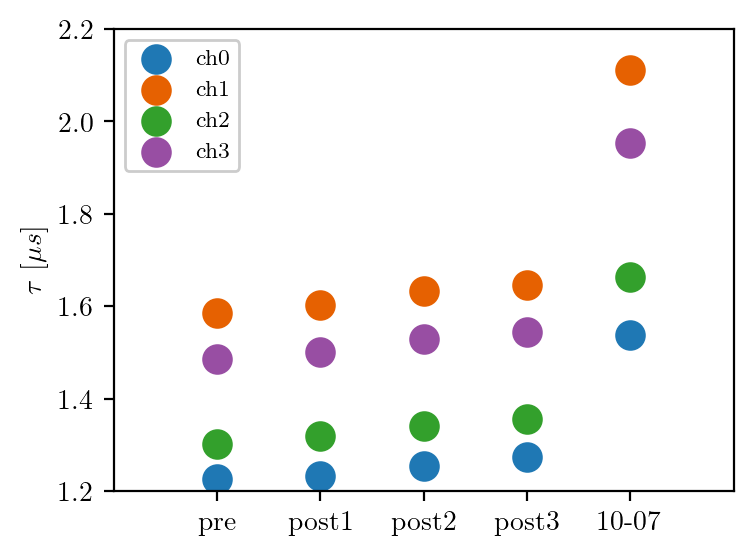

In [11]:
plt.figure()
for ch in range(4):
    plt.scatter(np.arange(len(tau_ch_datasets[ch])), tau_ch_datasets[ch],label='ch{}'.format(ch))
plt.ylabel(r'$\tau~[\mu s]$')
plt.xticks(np.arange(len(tau_ch_datasets[ch])),labels=['pre','post1','post2','post3','10-07'])
plt.xlim(-1,5)
plt.legend()

# Theoretical Beta Spectra of $^{90}\rm Sr$/$^{90}\rm Y$
Ref: https://academic.oup.com/ptps/article-lookup/doi/10.1143/PTPS.26.1

$$P(E) = C F(Z,E) p E (Q - T)^2$$
$$F(Z,E)=\frac{2(1+S)}{\Gamma(1+2S)^2} (2pR_N)^{2(S-1)} e^{\pi\eta} |\Gamma(S+i\eta|^2$$
* $R_N=A^{1/3}\times1.2\rm fm$
* $S=\sqrt{1-\alpha^2 Z^2}$
* $\eta = \frac{\alpha Z E}{p}$
* $Q(^{90}\rm Sr) = 0.546\rm MeV$
* $Q(^{90}\rm Y) = 2.28\rm MeV$

In [33]:
from scipy.special import gamma
import numpy as np
import scipy.integrate as integrate
Q_SR90 = 0.546e3 #keV
Q_Y90 = 2.28e3 #keV 
Z_Y90 = 39
Z_ZR90 = 40
A_SR90 = 90
ALPHA = 1/137
HBAR = 6.582e-19 #keV-s
C = 3e8 #m/s
M_ELE = 511 #keV

def Fermi_function(T: float, Z: int, A: int) -> float:
    '''
    Z: atomic number of final state nucleus
    A: mass number of final state nucleus
    T: kinetic energy in keV
    '''
    E = M_ELE + T #keV
    p = np.sqrt(E**2 - M_ELE**2) #keV
    S = np.sqrt(1-(ALPHA*Z)**2)
    eta = ALPHA*Z*E/p
    R_N = A**(1/3)*1.2e-15 #m
    return 2*(1+S)/gamma(1+2*S)**2 * (2*p*R_N/HBAR/C)**(2*(S-1)) * np.exp(np.pi*eta) * abs(gamma(complex(S, eta)))**2

def beta_shape(T: float, Q: float, C: float, Z: int, A: int) -> float:
    '''
    T: kinetic energy in keV
    Q: maximum energy in keV
    C: normalization constant
    Z: atomic number of final state nucleus
    A: mass number of final state nucleus
    '''
    if T>Q:
        return 0
    else:
        E = M_ELE + T #keV
        p = np.sqrt(E**2-M_ELE**2) #keV
        return C*Fermi_function(E,Z,A)*p*E*(Q-T)**2

def beta_shape_norm(Q: float, Z: int, A: int) -> float:
    return integrate.quad(lambda x: beta_shape(x, Q, 1, Z, A), 0, Q)

Text(0, 0.5, 'Rate [A.U.]')

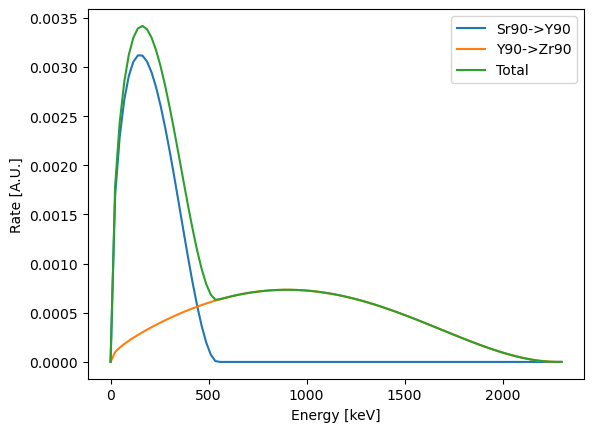

In [39]:
from locale import AM_STR
import matplotlib.pyplot as plt
energy = np.linspace(0, 2300, 100)
norm_sr90, _ = beta_shape_norm(Q=Q_SR90, Z=Z_Y90, A=A_SR90)
norm_y90, _ = beta_shape_norm(Q=Q_Y90, Z=Z_ZR90, A=A_SR90)
plt.plot(energy, [beta_shape(T=energy_, Q=Q_SR90, C=1/norm_sr90, Z=Z_Y90, A=A_SR90) for energy_ in energy], label='Sr90->Y90')
plt.plot(energy, [beta_shape(T=energy_, Q=Q_Y90, C=1/norm_y90, Z=Z_ZR90, A=A_SR90) for energy_ in energy], label='Y90->Zr90')
plt.plot(energy, [beta_shape(T=energy_, Q=Q_SR90, C=1/norm_sr90, Z=Z_Y90, A=A_SR90)+beta_shape(T=energy_, Q=Q_Y90, C=1/norm_y90, Z=Z_ZR90, A=A_SR90) for energy_ in energy], label='Total')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel('Rate [A.U.]')